In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
!pip install transformers

In [3]:
import torch 
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader,SubsetRandomSampler
import torch.optim as optim

import os
import copy
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pylab import rcParams
import csv
import time
from tqdm import tqdm
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

from transformers import AutoTokenizer,AutoModel,AutoModelForSequenceClassification,AdamW,get_linear_schedule_with_warmup ,AutoConfig , BertTokenizer, BertForSequenceClassification

seed_val = 42 
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [4]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print("Running on gpu",torch.cuda.get_device_name(0))
else:
    device = 'cpu'
    print('No GPU found Running on cpu')

Running on gpu Tesla T4


In [5]:
train_df = pd.read_csv('/kaggle/input/amazon-product-length-prediction-dataset/dataset/train.csv')
test_df = pd.read_csv('/kaggle/input/amazon-product-length-prediction-dataset/dataset/test.csv')
sample_df = pd.read_csv('/kaggle/input/amazon-product-length-prediction-dataset/dataset/sample_submission.csv')

In [6]:
train_df['TITLE'].isnull().sum()

12

In [7]:
len(train_df)-len(train_df.drop_duplicates())

0

NO duplicates present

In [8]:
train_df = train_df[train_df['TITLE'].notnull()]

In [9]:
train_df.head()

,PRODUCT_ID,TITLE,BULLET_POINTS,DESCRIPTION,PRODUCT_TYPE_ID,PRODUCT_LENGTH
0,1925202,ArtzFolio Tulip Flowers Blackout Curtain for D...,[LUXURIOUS & APPEALING: Beautiful custom-made ...,NaN,1650,2125.980000
1,2673191,Marks & Spencer Girls' Pyjama Sets T86_2561C_N...,"[Harry Potter Hedwig Pyjamas (6-16 Yrs),100% c...",NaN,2755,393.700000
2,2765088,PRIKNIK Horn Red Electric Air Horn Compressor ...,"[Loud Dual Tone Trumpet Horn, Compatible With ...","Specifications: Color: Red, Material: Aluminiu...",7537,748.031495
3,1594019,ALISHAH Women's Cotton Ankle Length Leggings C...,[Made By 95%cotton and 5% Lycra which gives yo...,AISHAH Women's Lycra Cotton Ankel Leggings. Br...,2996,787.401574
4,283658,The United Empire Loyalists: A Chronicle of th...,NaN,NaN,6112,598.424000


In [10]:
train_df= train_df.sample(100000)

In [11]:
train_df.shape

(100000, 6)

In [12]:
sentences = train_df['TITLE'].values 
labels = train_df['PRODUCT_LENGTH'].values

In [13]:
labels

array([ 433.07      ,  838.58267631,   19.685     , ..., 1181.102361  ,
        800.        , 1141.7322823 ])

In [14]:
print(sentences.shape,labels.shape)

(100000,) (100000,)


In [15]:
train_sentences, val_sentences,train_labels,val_labels = train_test_split(sentences,labels,test_size = 0.2,random_state=seed_val)

In [16]:
print(f"No. of training sentences {len(train_sentences)}")
print(f"No. of validation sentences {len(val_sentences)}")

No. of training sentences 80000
No. of validation sentences 20000


In [17]:
model_name = 'bert-base-uncased'
max_input_length = 128
batch_size = 64

In [18]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# model = BertRegressor.from_pretrained('bert-base-uncased')

In [20]:
idx = 10000
sample_text = sentences[idx]
tokens =tokenizer.tokenize(sample_text)
token_ids = tokenizer.convert_tokens_to_ids(tokens)
print('Sample text {}'.format(sample_text))
print('Tokens {}'.format(tokens))
print('Token IDS {}'.format(token_ids))

Sample text Dream Homme 200 GSM Microfibre Reversible Comforter Double Bed (Glowing Grey & Pretty Peach) 1 Piece
Tokens ['dream', 'homme', '200', 'gs', '##m', 'micro', '##fi', '##bre', 'rev', '##ers', '##ible', 'comfort', '##er', 'double', 'bed', '(', 'glowing', 'grey', '&', 'pretty', 'peach', ')', '1', 'piece']
Token IDS [3959, 26574, 3263, 28177, 2213, 12702, 8873, 13578, 7065, 2545, 7028, 7216, 2121, 3313, 2793, 1006, 10156, 4462, 1004, 3492, 18237, 1007, 1015, 3538]


In [21]:
encoding = tokenizer.encode_plus(
    sample_text,
    max_length = max_input_length,
    add_special_tokens = True,
    pad_to_max_length=True,
    return_attention_mask = True,
    return_token_type_ids = False,
    return_tensors = 'pt'
)

input_ids = encoding['input_ids']
attention_mask = encoding['attention_mask']


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2352: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [22]:
encoding

{'input_ids': tensor([[  101,  3959, 26574,  3263, 28177,  2213, 12702,  8873, 13578,  7065,
          2545,  7028,  7216,  2121,  3313,  2793,  1006, 10156,  4462,  1004,
          3492, 18237,  1007,  1015,  3538,   102,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,  

In [23]:
encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [24]:
# Load the pre-trained BERT model configuration with 768 hidden units
config = AutoConfig.from_pretrained(model_name, hidden_size=768)

# Load the pre-trained BERT model
base_model = AutoModel.from_pretrained('bert-base-uncased', config=config)

# Freeze the parameters of the pre-trained BERT model
for param in base_model.parameters():
    param.requires_grad = False

# Add a new output layer for regression
base_model.pooler = nn.Linear(config.hidden_size, 1)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [25]:
base_model(**encoding)['pooler_output']

tensor([[[ 1.7150e-01],
         [-2.3769e-01],
         [ 2.2204e-01],
         [-1.5723e-02],
         [ 2.9161e-01],
         [ 4.5334e-01],
         [ 4.0109e-01],
         [ 3.8685e-01],
         [ 3.1239e-01],
         [ 3.1975e-01],
         [ 5.2331e-01],
         [ 4.8750e-01],
         [ 3.7797e-01],
         [ 5.8159e-01],
         [ 2.8641e-01],
         [ 2.4587e-01],
         [ 4.6253e-01],
         [-8.1294e-02],
         [-2.3663e-01],
         [ 6.7542e-02],
         [ 2.1351e-01],
         [ 1.4472e-01],
         [-4.2979e-02],
         [-1.6302e-01],
         [ 5.2513e-01],
         [ 5.5770e-04],
         [-8.7731e-03],
         [-5.5674e-02],
         [ 3.7276e-02],
         [-9.3443e-02],
         [ 7.5440e-02],
         [-2.7459e-02],
         [ 2.4697e-02],
         [ 6.0851e-03],
         [-1.4299e-01],
         [ 2.6261e-02],
         [-8.5588e-02],
         [-6.9016e-02],
         [ 6.5341e-02],
         [ 2.6755e-02],
         [ 6.7161e-02],
         [ 3.647

In [26]:
class RegressionDataset(Dataset):
  
  def __init__(self, sentences, targets, tokenizer, max_length):
    self.sentences = sentences
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_length = max_length
  
  def __len__(self):
    return len(self.sentences)
  
  def __getitem__(self, idx):
    sentence = str(self.sentences[idx])
    target = float(self.targets[idx])
    encoding = self.tokenizer.encode_plus(
      sentence,
      add_special_tokens=True,
      max_length=self.max_length,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
        'sentence': sentence,
        'input_ids': encoding['input_ids'].flatten(),
        'attention_mask': encoding['attention_mask'].flatten(),
        'targets': torch.tensor(target, dtype=torch.float)
    }


In [27]:
def create_data_loaders(sentences, targets, tokenizer, max_input_length, batch_size):
    ds = RegressionDataset(
        sentences=sentences,
        targets=targets,
        tokenizer=tokenizer,
        max_length=max_input_length
    )

    return DataLoader(
        ds,
        batch_size=batch_size
    )

In [28]:
train_loader = create_data_loaders(
    train_sentences,
    train_labels,
    tokenizer,
    max_input_length=max_input_length,
    batch_size=batch_size
)

val_loader = create_data_loaders(
    val_sentences,
    val_labels,
    tokenizer,
    max_input_length=max_input_length,
    batch_size=batch_size
)


In [29]:
class AmazonRegressor(nn.Module):

  def __init__(self, base_model_name):
    super(AmazonRegressor, self).__init__()
    self.base_model = AutoModel.from_pretrained(base_model_name)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.base_model.config.hidden_size, 1)
  
  def forward(self, input_ids, attention_mask):
    pooled_output = self.base_model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )['pooler_output']
    output = self.drop(pooled_output)
    return self.out(output)


In [30]:
model = AmazonRegressor(base_model_name=model_name)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [31]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = AmazonRegressor(base_model_name=model_name)
model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


AmazonRegressor(
  (base_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_aff

In [32]:
num_epochs = 2

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)

total_steps = len(train_loader) * num_epochs

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.MSELoss().to(device)


/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:395: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [33]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  
  for i, d in enumerate(data_loader):
    if i % 100 == 0:
        print(f"Processing batch {i+1}/{len(data_loader)}")
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    loss = loss_fn(outputs.squeeze(-1), targets)

    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return np.mean(losses)


In [34]:
import torch.nn.functional as F

def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  total_squared_error = 0.0

  with torch.no_grad():
    for i,d in enumerate(data_loader):
      if i%100 == 0:
          print(f"Processing batch {i+1}/{len(data_loader)}")
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      print("Eval model keys:", d.keys())  # print out keys of dictionary

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )

      loss = loss_fn(outputs.squeeze(), targets.float().squeeze())

      losses.append(loss.item())

      # calculate squared error
      squared_error = F.mse_loss(outputs.squeeze(), targets.float(), reduction='none')
      total_squared_error += squared_error.sum().item()

  mse = total_squared_error / n_examples

  return mse, np.mean(losses)



In [35]:
# %%time

# history = defaultdict(list)
# best_loss = float('inf')

# for epoch in tqdm(range(num_epochs)):

#   print(f'Epoch {epoch + 1}/{num_epochs}')
#   print('-' * 10)

#   train_loss = train_epoch(
#     model,
#     train_loader,    
#     loss_fn, 
#     optimizer, 
#     device, 
#     scheduler, 
#     len(train_labels)
#   )

#   print(f'Train loss {train_loss}')

#   val_loss = eval_model(
#     model,
#     val_loader,
#     loss_fn, 
#     device, 
#     len(val_labels)
#   )

#   print(f'Val   loss {val_loss}')
#   print()

#   history['train_loss'].append(train_loss)
#   history['val_loss'].append(val_loss)

#   if val_loss < best_loss:
#     torch.save(model.state_dict(), 'best_model_state.bin')
#     best_loss = val_loss


In [36]:
%%time

history = defaultdict(list)
best_loss = float('inf')

for epoch in tqdm(range(num_epochs)):

  print(f'Epoch {epoch + 1}/{num_epochs}')
  print('-' * 10)

  train_loss = train_epoch(
    model,
    train_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(train_labels)
  )

  print(f'Train loss {train_loss}')

  val_loss, val_mse = eval_model(
    model,
    val_loader,
    loss_fn, 
    device, 
    len(val_labels)
  )

  print(f'Val   loss {val_loss} and Val mse {val_mse}')
  print()

  history['train_loss'].append(train_loss)
  history['val_loss'].append(val_loss)
  history['val_mse'].append(val_mse)

  if val_loss < best_loss:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_loss = val_loss
    print("Saving best model state...")

  # save the model's state every 5 epochs
  if (epoch + 1) % 5 == 0:
    torch.save(model.state_dict(), f'model_state_epoch{epoch+1}.bin')
    print(f"Saving model state for epoch {epoch+1}...")  


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1/2
----------
Processing batch 1/1250
Processing batch 101/1250
Processing batch 201/1250
Processing batch 301/1250
Processing batch 401/1250
Processing batch 501/1250
Processing batch 601/1250
Processing batch 701/1250
Processing batch 801/1250
Processing batch 901/1250
Processing batch 1001/1250
Processing batch 1101/1250
Processing batch 1201/1250
Train loss 8400869523.18425
Processing batch 1/313
Eval model keys: dict_keys(['sentence', 'input_ids', 'attention_mask', 'targets'])
Eval model keys: dict_keys(['sentence', 'input_ids', 'attention_mask', 'targets'])
Eval model keys: dict_keys(['sentence', 'input_ids', 'attention_mask', 'targets'])
Eval model keys: dict_keys(['sentence', 'input_ids', 'attention_mask', 'targets'])
Eval model keys: dict_keys(['sentence', 'input_ids', 'attention_mask', 'targets'])
Eval model keys: dict_keys(['sentence', 'input_ids', 'attention_mask', 'targets'])
Eval model keys: dict_keys(['sentence', 'input_ids', 'attention_mask', 'targets'])
Eval mod

 50%|█████     | 1/2 [29:07<29:07, 1747.21s/it]

Saving best model state...
Epoch 2/2
----------
Processing batch 1/1250
Processing batch 101/1250
Processing batch 201/1250
Processing batch 301/1250
Processing batch 401/1250
Processing batch 501/1250
Processing batch 601/1250
Processing batch 701/1250
Processing batch 801/1250
Processing batch 901/1250
Processing batch 1001/1250
Processing batch 1101/1250
Processing batch 1201/1250
Train loss 8400809221.3649
Processing batch 1/313
Eval model keys: dict_keys(['sentence', 'input_ids', 'attention_mask', 'targets'])
Eval model keys: dict_keys(['sentence', 'input_ids', 'attention_mask', 'targets'])
Eval model keys: dict_keys(['sentence', 'input_ids', 'attention_mask', 'targets'])
Eval model keys: dict_keys(['sentence', 'input_ids', 'attention_mask', 'targets'])
Eval model keys: dict_keys(['sentence', 'input_ids', 'attention_mask', 'targets'])
Eval model keys: dict_keys(['sentence', 'input_ids', 'attention_mask', 'targets'])
Eval model keys: dict_keys(['sentence', 'input_ids', 'attention_m

100%|██████████| 2/2 [58:19<00:00, 1749.95s/it]

Saving best model state...
CPU times: user 57min 53s, sys: 11.1 s, total: 58min 4s
Wall time: 58min 19s


In [37]:
val_acc, val_loss = eval_model(
model,
val_loader,
loss_fn, 
device, 
len(val_labels)
)

print(f'Val   loss {val_loss} accuracy {val_acc}')

Processing batch 1/313
Eval model keys: dict_keys(['sentence', 'input_ids', 'attention_mask', 'targets'])
Eval model keys: dict_keys(['sentence', 'input_ids', 'attention_mask', 'targets'])
Eval model keys: dict_keys(['sentence', 'input_ids', 'attention_mask', 'targets'])
Eval model keys: dict_keys(['sentence', 'input_ids', 'attention_mask', 'targets'])
Eval model keys: dict_keys(['sentence', 'input_ids', 'attention_mask', 'targets'])
Eval model keys: dict_keys(['sentence', 'input_ids', 'attention_mask', 'targets'])
Eval model keys: dict_keys(['sentence', 'input_ids', 'attention_mask', 'targets'])
Eval model keys: dict_keys(['sentence', 'input_ids', 'attention_mask', 'targets'])
Eval model keys: dict_keys(['sentence', 'input_ids', 'attention_mask', 'targets'])
Eval model keys: dict_keys(['sentence', 'input_ids', 'attention_mask', 'targets'])
Eval model keys: dict_keys(['sentence', 'input_ids', 'attention_mask', 'targets'])
Eval model keys: dict_keys(['sentence', 'input_ids', 'attention_

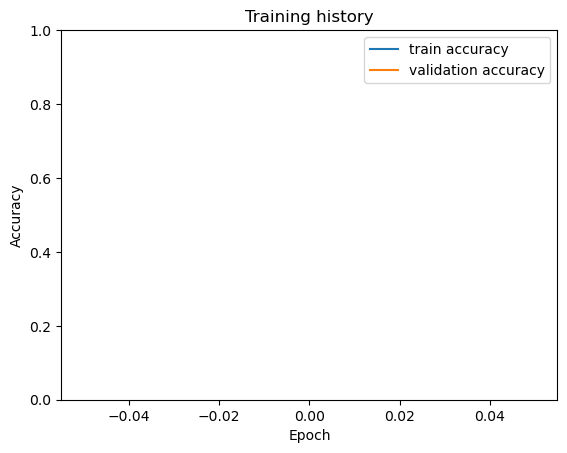

In [39]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);